Use MQL5, do not ever mix MT4-style functions in MT5, do not ever use the MT4-style helper, {make an expert advisor that market-buy order at the close of the bullish H3 candle (0:00 to 3:00 bar). Place the stop-loss at the low of the corresponding H3 candle. Its 1% risk per trade accounting the full distance of the stoploss. The take-profit will depend on the stoploss-trailing mechanic. Only trail the stoploss at the lows of preceding bullish candles; skip the bearish candles.}

Use MQL5, do not ever mix MT4-style functions in MT5, do not ever use the MT4-style helper, 

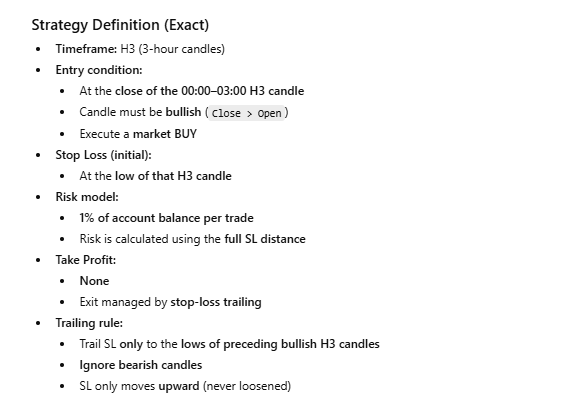

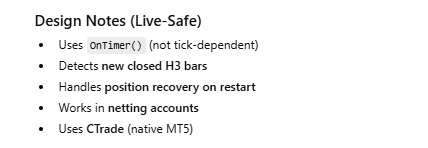


In [ ]:
#property strict

#include <Trade/Trade.mqh>

CTrade trade;

// --------------------
// Inputs
// --------------------
input double RiskPercent = 1.0;   // 1% risk per trade
input int    TimerSec    = 5;     // execution interval (seconds)

// --------------------
// Globals
// --------------------
datetime lastH3CloseTime = 0;
string   TradeSymbol;

// --------------------
// Initialization
// --------------------
int OnInit()
{
   TradeSymbol = _Symbol;

   if(!SymbolSelect(TradeSymbol, true))
      return INIT_FAILED;

   EventSetTimer(TimerSec);
   return INIT_SUCCEEDED;
}

// --------------------
// Deinitialization
// --------------------
void OnDeinit(const int reason)
{
   EventKillTimer();
}

// --------------------
// Timer Event
// --------------------
void OnTimer()
{
   HandleEntry();
   HandleTrailing();
}

// --------------------
// ENTRY LOGIC
// --------------------
void HandleEntry()
{
   // Only one position per symbol (netting-safe)
   if(PositionSelect(TradeSymbol))
      return;

   // Get last closed H3 candle
   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastH3CloseTime)
      return;

   lastH3CloseTime = barTime;

   // Check it is the 00:00–03:00 candle
   MqlDateTime t;
   TimeToStruct(barTime, t);
   if(t.hour != 0)
      return;

   double open  = iOpen (TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow  (TradeSymbol, PERIOD_H3, 1);

   // Must be bullish
   if(close <= open)
      return;

   double entryPrice = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
   double stopLoss   = low;

   double volume = CalculateRiskVolume(entryPrice, stopLoss);
   if(volume <= 0)
      return;

   trade.SetDeviationInPoints(20);
   trade.SetTypeFillingBySymbol(TradeSymbol);

   trade.Buy(volume, TradeSymbol, entryPrice, stopLoss, 0.0);
}

// --------------------
// TRAILING STOP LOGIC
// --------------------
void HandleTrailing()
{
   if(!PositionSelect(TradeSymbol))
      return;

   double currentSL = PositionGetDouble(POSITION_SL);
   double priceOpen = PositionGetDouble(POSITION_PRICE_OPEN);

   // Scan previous closed H3 candles
   for(int i = 1; i < 50; i++)
   {
      double open  = iOpen (TradeSymbol, PERIOD_H3, i);
      double close = iClose(TradeSymbol, PERIOD_H3, i);
      double low   = iLow  (TradeSymbol, PERIOD_H3, i);

      // Only bullish candles
      if(close <= open)
         continue;

      // SL must only move up
      if(low <= currentSL || low <= priceOpen)
         continue;

      trade.PositionModify(TradeSymbol, low, 0.0);
      break;
   }
}

// --------------------
// RISK-BASED LOT CALC
// --------------------
double CalculateRiskVolume(double entry, double stop)
{
   double balance = AccountInfoDouble(ACCOUNT_BALANCE);
   double riskAmt = balance * (RiskPercent / 100.0);

   double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
   double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

   double distance = MathAbs(entry - stop);
   if(distance <= 0)
      return 0;

   double costPerLot = (distance / tickSize) * tickValue;
   if(costPerLot <= 0)
      return 0;

   double volume = riskAmt / costPerLot;

   double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
   double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
   double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

   volume = MathFloor(volume / stepLot) * stepLot;
   volume = MathMax(volume, minLot);
   volume = MathMin(volume, maxLot);

   return volume;
}


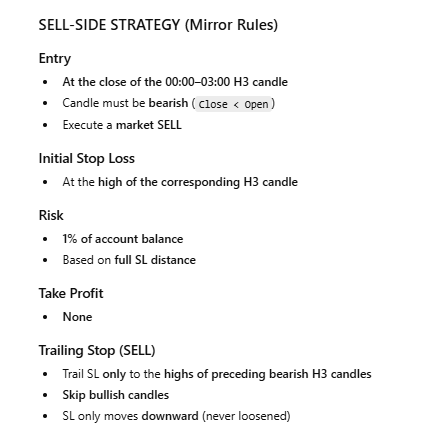

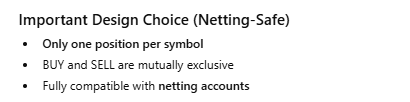

In [ ]:
#property strict

#include <Trade/Trade.mqh>

CTrade trade;

// --------------------
// Inputs
// --------------------
input double RiskPercent = 1.0;
input int    TimerSec    = 5;

// --------------------
// Globals
// --------------------
datetime lastH3CloseTime = 0;
string   TradeSymbol;

// --------------------
// Initialization
// --------------------
int OnInit()
{
   TradeSymbol = _Symbol;

   if(!SymbolSelect(TradeSymbol, true))
      return INIT_FAILED;

   EventSetTimer(TimerSec);
   return INIT_SUCCEEDED;
}

// --------------------
void OnDeinit(const int reason)
{
   EventKillTimer();
}

// --------------------
void OnTimer()
{
   HandleEntry();
   HandleTrailing();
}

// ============================================================
// ENTRY LOGIC (BUY + SELL)
// ============================================================
void HandleEntry()
{
   if(PositionSelect(TradeSymbol))
      return;

   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastH3CloseTime)
      return;

   lastH3CloseTime = barTime;

   MqlDateTime t;
   TimeToStruct(barTime, t);
   if(t.hour != 0)
      return;

   double open  = iOpen (TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow  (TradeSymbol, PERIOD_H3, 1);
   double high  = iHigh (TradeSymbol, PERIOD_H3, 1);

   trade.SetDeviationInPoints(20);
   trade.SetTypeFillingBySymbol(TradeSymbol);

   // ---------------- BUY ----------------
   if(close > open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
      double sl    = low;

      double vol = CalculateRiskVolume(entry, sl);
      if(vol > 0)
         trade.Buy(vol, TradeSymbol, entry, sl, 0.0);
   }

   // ---------------- SELL ----------------
   if(close < open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
      double sl    = high;

      double vol = CalculateRiskVolume(entry, sl);
      if(vol > 0)
         trade.Sell(vol, TradeSymbol, entry, sl, 0.0);
   }
}

// ============================================================
// TRAILING STOP LOGIC (DIRECTION AWARE)
// ============================================================
void HandleTrailing()
{
   if(!PositionSelect(TradeSymbol))
      return;

   long   type      = PositionGetInteger(POSITION_TYPE);
   double currentSL = PositionGetDouble(POSITION_SL);
   double openPrice = PositionGetDouble(POSITION_PRICE_OPEN);

   for(int i = 1; i < 50; i++)
   {
      double open  = iOpen (TradeSymbol, PERIOD_H3, i);
      double close = iClose(TradeSymbol, PERIOD_H3, i);
      double low   = iLow  (TradeSymbol, PERIOD_H3, i);
      double high  = iHigh (TradeSymbol, PERIOD_H3, i);

      // ---------------- BUY TRAIL ----------------
      if(type == POSITION_TYPE_BUY)
      {
         if(close <= open) continue;           // skip bearish
         if(low <= currentSL) continue;
         if(low <= openPrice) continue;

         trade.PositionModify(TradeSymbol, low, 0.0);
         break;
      }

      // ---------------- SELL TRAIL ----------------
      if(type == POSITION_TYPE_SELL)
      {
         if(close >= open) continue;           // skip bullish
         if(high >= currentSL) continue;
         if(high >= openPrice) continue;

         trade.PositionModify(TradeSymbol, high, 0.0);
         break;
      }
   }
}

// ============================================================
// RISK-BASED LOT CALC (DIRECTION AGNOSTIC)
// ============================================================
double CalculateRiskVolume(double entry, double stop)
{
   double balance = AccountInfoDouble(ACCOUNT_BALANCE);
   double riskAmt = balance * (RiskPercent / 100.0);

   double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
   double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

   double distance = MathAbs(entry - stop);
   if(distance <= 0)
      return 0;

   double costPerLot = (distance / tickSize) * tickValue;
   if(costPerLot <= 0)
      return 0;

   double volume = riskAmt / costPerLot;

   double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
   double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
   double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

   volume = MathFloor(volume / stepLot) * stepLot;
   volume = MathMax(volume, minLot);
   volume = MathMin(volume, maxLot);

   return volume;
}
